In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv(r"C:\Users\sappa\Downloads\beverage_dataset_1000_rows.xls")

In [2]:
df['Expiry_Date (YYYY-MM-DD)'] = pd.to_datetime(df['Expiry_Date (YYYY-MM-DD)'], errors='coerce')
df['Production_Date (YYYY-MM-DD)'] = pd.to_datetime(df['Production_Date (YYYY-MM-DD)'], errors='coerce')

# Calculate shelf life in weeks
df['Target_Shelf_Life_Weeks'] = (df['Expiry_Date (YYYY-MM-DD)'] - df['Production_Date (YYYY-MM-DD)']).dt.days / 7

# Drop the old column
df = df.drop(columns=['Target_Shelf_Life (hr)'])
df.shape

(1000, 72)

In [3]:
import math

def calculation_outputs(df):
    
    # values of all constants
    
    k=0.02 # per hour
    Ea=45 # KJ/mol
    R=0.008314 # KJ/mol
    alpha=0.05
    beta=0.002
    risk_temp_wt=1.3
    risk_microbe_wt=1.5
    risk_delay_wt=1
    risk_shelf_wt=1.5
    urgency_penalty=5
    
    a=0.03
    b=0.03
    c=0.01
    d=-0.3
    markdown_scale=5
    recomm_temp_wt=0.3
    recomm_hum_wt=0.2
    reroute_delay_threshould=12 # hours
    reroute_breach_threshould=2
    risk_threshold=85
    MIN_DEGRADATION_RATE = 0.05  # Minimum degradation rate (per hour)
    BASE_DEGRADATION_RATE = 0.02  # Base rate at optimal temp
    TARGET_FRESHNESS_THRESHOLD = 50  # Freshness level at target shelf life end
    min_degradation_threshold=0.01
    

    
    def c_to_k(c):
        return c + 273.15
    
    degradation_rates=[]
    freshness_scores=[]
    remaining_shelf_lives=[]
    risk_scores=[]
    spoilage_probabilities=[]
    high_risk_flags=[]
    reroute_flags=[]
    markdown_urgency_levels=[]
    recommended_temps=[]
    recommended_hums=[]
    max_allowed_transit_times=[]
    
    for idx, row in df.iterrows():
        T_opt = c_to_k(row['Optimal_Temp_Max (°C)'])
        T_curr = c_to_k(row['Current_Temperature (°C)'])
        storage_duration = row['Storage_Duration (hr)']
        microbial_count = row['Microbial_Count (CFU/mL)']
        transit_delay = row['Transit_Delay_Hours (hr)']
        cold_chain_breaches = row['Cold_Chain_Breaches (count)']
        ammonia_release = row['Ammonia_Release_Rate (ppm)']
        max_humidity_exc = row['Max_Humidity_Excursion (%)']
        priority = row['Priority_Level (1-10)']
        target_shelf_life = row['Target_Shelf_Life_Weeks']
        current_humidity=row['Current_Humidity (%)']
        
        ## building formulae 
        #degradation rate
        arrhenius_factor=math.exp(Ea/R*((1/T_opt)-(1/T_curr)))
        
        degradation_rate=k*arrhenius_factor*(1+alpha*storage_duration)
        
        degradation_rate=min(degradation_rate,10)
        
        # freshness score
        
        freshness = 100 - (degradation_rate ** 1.2) * storage_duration -  5* np.log1p(microbial_count)
        freshness_score=max(min(freshness,100),0)
        
        # rem shelf life
        
        
        remaining_shelf_life=target_shelf_life*(freshness_score/100)*(0.02/degradation_rate)
        
        
        
        
        # risk score
        
        temp_dev=max(0,row['Current_Temperature (°C)']-row['Optimal_Temp_Max (°C)'])
        temp_dev=min(temp_dev*5,100)
        microbial_risk = min(100, microbial_count / 200)
        delay_impact = min(transit_delay *100/72,100)
        
        if target_shelf_life > 0:
            shelf_life_factor = (1 - min(remaining_shelf_life / target_shelf_life, 1.0)) * 100
        else:
            shelf_life_factor = 100 
        risk_score=risk_temp_wt*temp_dev +risk_microbe_wt*microbial_risk + risk_delay_wt*delay_impact+ risk_shelf_wt*shelf_life_factor -18
        risk_score = 100 / (1 + np.exp(-0.05 * (risk_score - 60)))
        risk_score=max(min(risk_score,100),0)
        # spoilage_probability
        
        logit=a*risk_score+b*ammonia_release+c*max_humidity_exc  +d*remaining_shelf_life
        spoilage_probability=1/(1+math.exp(-logit))
        
        
        # high risk flag
        
        high_risk_flag=1 if risk_score>risk_threshold else 0
        
        # reroute recommend flag
        reroute_flag = 1 if (transit_delay>reroute_delay_threshould or cold_chain_breaches > reroute_breach_threshould) else 0
        
        urgency_raw = ((1 - freshness / 100)**2) * (priority / 10) * markdown_scale + 2.5*spoilage_probability
        if spoilage_probability > 0.95:
            urgency_raw = max(urgency_raw, 5)
        markdown_urgency = min(max(int(round(urgency_raw)), 1), 5)
        
        target_temp = (row['Optimal_Temp_Min (°C)'] + row['Optimal_Temp_Max (°C)']) / 2
        correction_factor = 0.5
        recommended_temp = row['Current_Temperature (°C)'] + correction_factor * (target_temp - row['Current_Temperature (°C)'])
        recommended_temp = min(max(recommended_temp, row['Optimal_Temp_Min (°C)']), row['Optimal_Temp_Max (°C)'])
        
        target_hum = (row['Optimal_Humidity_Min (%)'] + row['Optimal_Humidity_Max (%)']) / 2
        correction_factor = 0.5  # How aggressively to correct

        recommended_hum = current_humidity + correction_factor * (target_hum - current_humidity)
# Clamp to allowed range
        recommended_hum = min(max(recommended_hum, row['Optimal_Humidity_Min (%)']), row['Optimal_Humidity_Max (%)'])
        
        remaining_shelf_life_hours=remaining_shelf_life*7*24
        urgency_flag=remaining_shelf_life<1
        urgency_penalty = 6  
        if urgency_flag:
            adjusted_transit_delay=max(transit_delay-urgency_penalty,0)
        else:
            adjusted_transit_delay=transit_delay
        max_transit_time = max(0.8*remaining_shelf_life_hours -0.5*adjusted_transit_delay , 0)
        
        degradation_rates.append(degradation_rate)
        freshness_scores.append(freshness)
        risk_scores.append(risk_score)
        remaining_shelf_lives.append(remaining_shelf_life)
        spoilage_probabilities.append(spoilage_probability)
        high_risk_flags.append(high_risk_flag)
        reroute_flags.append(reroute_flag)
        markdown_urgency_levels.append(markdown_urgency)
        recommended_temps.append(recommended_temp)
        recommended_hums.append(recommended_hum)
        max_allowed_transit_times.append(max_transit_time)
        
    df['Degradation_Rate'] = degradation_rates
    df['Freshness_Score'] = freshness_scores
    df['Risk_Score'] = risk_scores
    df['Remaining_Shelf_Life'] = remaining_shelf_lives
    df['Spoilage_Probability'] = spoilage_probabilities
    df['High_Risk_Flag'] = high_risk_flags
    df['Reroute_Recommended_Flag'] = reroute_flags
    df['Markdown_Urgency_Level'] = markdown_urgency_levels
    df['Recommended_Temperature'] = recommended_temps
    df['Recommended_Humidity'] = recommended_hums
    df['Max_Allowed_Transit_Time'] = max_allowed_transit_times

    return df

                
    
            
        

        
        
        
    
    
    

In [4]:
calculation_outputs(df)


,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,59.598705,90.447451,6.299582,0.730469,1,1,2,6.733730,70.151765,841.461346
2,SKU0003,Kombucha,Mango,PET,2025-06-23,2025-09-14,BATCH0003,6.065815,9.649784,7.598338,...,60.758434,60.454609,6.776904,0.478808,0,0,1,5.101447,82.925984,909.674465
3,SKU0004,Kombucha,Mango,Glass,2025-06-17,2025-07-26,BATCH0004,0.674011,1.859216,0.932912,...,63.562425,65.610594,3.080510,0.789412,0,1,2,2.723525,71.394590,409.239177
4,SKU0005,RTD Coffee,Cola,Glass,2025-06-24,2025-09-02,BATCH0005,1.588974,1.633956,2.048271,...,57.984453,41.140638,7.538563,0.305650,0,0,2,3.597795,77.949628,1012.990993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,SKU0996,Soda,Orange,Glass,2025-06-22,2025-08-11,BATCH0996,1.216070,1.565019,3.975086,...,61.600122,45.487468,4.493148,0.576278,0,1,2,3.313570,73.583437,602.887747
996,SKU0997,RTD Tea,Cola,Can,2025-06-20,2025-08-01,BATCH0997,5.644314,7.090071,2.458001,...,57.641519,93.359767,2.276818,0.904032,1,0,2,5.564481,70.584326,304.829177
997,SKU0998,Kombucha,Cola,Glass,2025-06-16,2025-07-18,BATCH0998,5.576072,9.638454,7.358590,...,60.208944,73.119877,2.351952,0.849410,0,0,3,4.307508,73.786361,314.589436
998,SKU0999,Soda,Mango,Tetra Pak,2025-06-20,2025-08-17,BATCH0999,0.498794,4.805411,6.737286,...,58.216034,43.692759,6.649516,0.369654,0,0,2,3.242737,81.610968,889.582379


In [5]:
df[df['Remaining_Shelf_Life']<1]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
8,SKU0009,Juice,Peach,Glass,2025-06-24,2025-07-11,BATCH0009,6.932493,11.354882,5.284452,...,66.067132,86.283055,0.918809,0.917712,1,0,3,5.733481,74.469941,120.991581
25,SKU0026,RTD Tea,Orange,Can,2025-06-19,2025-09-22,BATCH0026,22.685214,31.336962,20.118082,...,32.505418,99.999992,0.771549,0.982988,1,0,5,8.000000,79.872501,102.460906
44,SKU0045,Kombucha,Mango,Glass,2025-06-24,2025-07-12,BATCH0045,5.383156,7.947474,7.886342,...,63.829031,90.748811,0.830423,0.927974,1,0,3,5.009268,83.570898,110.016764
50,SKU0051,Kombucha,Ginger-Lime,Glass,2025-06-20,2025-07-26,BATCH0051,21.713909,28.676973,47.262929,...,30.471812,99.999982,0.319173,0.972993,1,1,5,8.000000,69.243216,40.963705
57,SKU0058,Kombucha,Apple,Tetra Pak,2025-06-22,2025-07-09,BATCH0058,6.763035,9.012191,3.138790,...,57.788537,96.089821,0.811182,0.937401,1,0,3,6.150540,66.972223,109.022818
75,SKU0076,Energy Drink,Apple,Glass,2025-06-17,2025-08-08,BATCH0076,12.655902,18.862046,47.454944,...,34.253236,99.999740,0.692052,0.978791,1,0,5,8.000000,84.191633,92.243725
100,SKU0101,Juice,Orange,PET,2025-06-18,2025-08-23,BATCH0101,22.833450,32.062916,31.693931,...,29.272540,99.999991,0.426311,0.980692,1,0,5,8.000000,71.886556,56.605526
117,SKU0118,Soda,Lemon,Glass,2025-06-23,2025-07-09,BATCH0118,0.597490,3.383277,3.817669,...,59.162749,91.924135,0.918356,0.930996,1,0,3,2.905591,71.315881,121.974295
125,SKU0126,Soda,Cola,PET,2025-06-16,2025-09-01,BATCH0126,20.513368,29.236910,12.576969,...,29.591058,99.999981,0.559625,0.967087,1,0,5,8.000000,82.169994,75.213655


In [6]:
df[df['High_Risk_Flag']==1]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,59.598705,90.447451,6.299582,0.730469,1,1,2,6.733730,70.151765,841.461346
6,SKU0007,Juice,Mango,Tetra Pak,2025-06-17,2025-07-31,BATCH0007,2.977608,6.016317,7.256808,...,58.633629,96.595154,1.984685,0.928935,1,0,3,4.141375,73.840760,261.018188
8,SKU0009,Juice,Peach,Glass,2025-06-24,2025-07-11,BATCH0009,6.932493,11.354882,5.284452,...,66.067132,86.283055,0.918809,0.917712,1,0,3,5.733481,74.469941,120.991581
14,SKU0015,RTD Tea,Apple,PET,2025-06-23,2025-08-19,BATCH0015,2.621241,5.100717,6.210616,...,58.285815,95.030355,2.688822,0.910667,1,1,3,4.049233,79.951262,358.529002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,SKU0991,Juice,Ginger-Lime,Glass,2025-06-17,2025-09-08,BATCH0991,1.361053,5.941460,4.439546,...,59.312132,90.026831,5.309039,0.769823,1,0,2,3.146313,70.815483,708.217927
991,SKU0992,Kombucha,Cola,Tetra Pak,2025-06-23,2025-09-03,BATCH0992,7.958096,12.721962,7.034102,...,58.289076,96.462045,3.993417,0.868365,1,0,3,6.524819,73.761015,531.390282
993,SKU0994,Energy Drink,Apple,Can,2025-06-20,2025-09-16,BATCH0994,6.911773,7.445446,3.099832,...,59.475084,86.978318,5.870347,0.739449,1,0,2,6.259215,79.612660,786.055981
994,SKU0995,Energy Drink,Ginger-Lime,Glass,2025-06-18,2025-08-28,BATCH0995,6.797326,8.858623,1.502612,...,57.989269,97.562574,2.575182,0.901018,1,0,3,5.637860,70.133840,342.228267


In [7]:
df=df[df['Freshness_Score']>=0].reset_index(drop=True)

In [8]:
df

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,59.598705,90.447451,6.299582,0.730469,1,1,2,6.733730,70.151765,841.461346
2,SKU0003,Kombucha,Mango,PET,2025-06-23,2025-09-14,BATCH0003,6.065815,9.649784,7.598338,...,60.758434,60.454609,6.776904,0.478808,0,0,1,5.101447,82.925984,909.674465
3,SKU0004,Kombucha,Mango,Glass,2025-06-17,2025-07-26,BATCH0004,0.674011,1.859216,0.932912,...,63.562425,65.610594,3.080510,0.789412,0,1,2,2.723525,71.394590,409.239177
4,SKU0005,RTD Coffee,Cola,Glass,2025-06-24,2025-09-02,BATCH0005,1.588974,1.633956,2.048271,...,57.984453,41.140638,7.538563,0.305650,0,0,2,3.597795,77.949628,1012.990993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,SKU0996,Soda,Orange,Glass,2025-06-22,2025-08-11,BATCH0996,1.216070,1.565019,3.975086,...,61.600122,45.487468,4.493148,0.576278,0,1,2,3.313570,73.583437,602.887747
996,SKU0997,RTD Tea,Cola,Can,2025-06-20,2025-08-01,BATCH0997,5.644314,7.090071,2.458001,...,57.641519,93.359767,2.276818,0.904032,1,0,2,5.564481,70.584326,304.829177
997,SKU0998,Kombucha,Cola,Glass,2025-06-16,2025-07-18,BATCH0998,5.576072,9.638454,7.358590,...,60.208944,73.119877,2.351952,0.849410,0,0,3,4.307508,73.786361,314.589436
998,SKU0999,Soda,Mango,Tetra Pak,2025-06-20,2025-08-17,BATCH0999,0.498794,4.805411,6.737286,...,58.216034,43.692759,6.649516,0.369654,0,0,2,3.242737,81.610968,889.582379


In [9]:
df[df['Remaining_Shelf_Life']>24]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time


In [10]:
df[df['High_Risk_Flag']==1]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,59.598705,90.447451,6.299582,0.730469,1,1,2,6.733730,70.151765,841.461346
6,SKU0007,Juice,Mango,Tetra Pak,2025-06-17,2025-07-31,BATCH0007,2.977608,6.016317,7.256808,...,58.633629,96.595154,1.984685,0.928935,1,0,3,4.141375,73.840760,261.018188
8,SKU0009,Juice,Peach,Glass,2025-06-24,2025-07-11,BATCH0009,6.932493,11.354882,5.284452,...,66.067132,86.283055,0.918809,0.917712,1,0,3,5.733481,74.469941,120.991581
14,SKU0015,RTD Tea,Apple,PET,2025-06-23,2025-08-19,BATCH0015,2.621241,5.100717,6.210616,...,58.285815,95.030355,2.688822,0.910667,1,1,3,4.049233,79.951262,358.529002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,SKU0991,Juice,Ginger-Lime,Glass,2025-06-17,2025-09-08,BATCH0991,1.361053,5.941460,4.439546,...,59.312132,90.026831,5.309039,0.769823,1,0,2,3.146313,70.815483,708.217927
991,SKU0992,Kombucha,Cola,Tetra Pak,2025-06-23,2025-09-03,BATCH0992,7.958096,12.721962,7.034102,...,58.289076,96.462045,3.993417,0.868365,1,0,3,6.524819,73.761015,531.390282
993,SKU0994,Energy Drink,Apple,Can,2025-06-20,2025-09-16,BATCH0994,6.911773,7.445446,3.099832,...,59.475084,86.978318,5.870347,0.739449,1,0,2,6.259215,79.612660,786.055981
994,SKU0995,Energy Drink,Ginger-Lime,Glass,2025-06-18,2025-08-28,BATCH0995,6.797326,8.858623,1.502612,...,57.989269,97.562574,2.575182,0.901018,1,0,3,5.637860,70.133840,342.228267


In [11]:
df[df['Markdown_Urgency_Level']>1] 

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,59.598705,90.447451,6.299582,0.730469,1,1,2,6.733730,70.151765,841.461346
3,SKU0004,Kombucha,Mango,Glass,2025-06-17,2025-07-26,BATCH0004,0.674011,1.859216,0.932912,...,63.562425,65.610594,3.080510,0.789412,0,1,2,2.723525,71.394590,409.239177
4,SKU0005,RTD Coffee,Cola,Glass,2025-06-24,2025-09-02,BATCH0005,1.588974,1.633956,2.048271,...,57.984453,41.140638,7.538563,0.305650,0,0,2,3.597795,77.949628,1012.990993
5,SKU0006,Juice,Lemon,Glass,2025-06-23,2025-07-29,BATCH0006,3.113941,5.176290,1.928273,...,59.219236,57.643941,3.145415,0.708232,0,0,2,3.273952,73.515609,422.687140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,SKU0995,Energy Drink,Ginger-Lime,Glass,2025-06-18,2025-08-28,BATCH0995,6.797326,8.858623,1.502612,...,57.989269,97.562574,2.575182,0.901018,1,0,3,5.637860,70.133840,342.228267
995,SKU0996,Soda,Orange,Glass,2025-06-22,2025-08-11,BATCH0996,1.216070,1.565019,3.975086,...,61.600122,45.487468,4.493148,0.576278,0,1,2,3.313570,73.583437,602.887747
996,SKU0997,RTD Tea,Cola,Can,2025-06-20,2025-08-01,BATCH0997,5.644314,7.090071,2.458001,...,57.641519,93.359767,2.276818,0.904032,1,0,2,5.564481,70.584326,304.829177
997,SKU0998,Kombucha,Cola,Glass,2025-06-16,2025-07-18,BATCH0998,5.576072,9.638454,7.358590,...,60.208944,73.119877,2.351952,0.849410,0,0,3,4.307508,73.786361,314.589436


In [12]:
df[(df['Risk_Score']>50) & (df['Risk_Score']<70)]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
2,SKU0003,Kombucha,Mango,PET,2025-06-23,2025-09-14,BATCH0003,6.065815,9.649784,7.598338,...,60.758434,60.454609,6.776904,0.478808,0,0,1,5.101447,82.925984,909.674465
3,SKU0004,Kombucha,Mango,Glass,2025-06-17,2025-07-26,BATCH0004,0.674011,1.859216,0.932912,...,63.562425,65.610594,3.080510,0.789412,0,1,2,2.723525,71.394590,409.239177
5,SKU0006,Juice,Lemon,Glass,2025-06-23,2025-07-29,BATCH0006,3.113941,5.176290,1.928273,...,59.219236,57.643941,3.145415,0.708232,0,0,2,3.273952,73.515609,422.687140
12,SKU0013,Soda,Lemon,Glass,2025-06-20,2025-08-21,BATCH0013,4.256935,6.749672,1.250317,...,65.086596,50.380515,4.840345,0.561762,0,0,2,4.460623,72.837949,649.688111
15,SKU0016,Kombucha,Berry,Tetra Pak,2025-06-24,2025-08-28,BATCH0016,4.581146,7.160251,0.343705,...,60.601561,61.394952,6.134748,0.514436,0,0,2,4.585960,73.309245,818.520166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,SKU0965,RTD Coffee,Cola,Can,2025-06-21,2025-07-19,BATCH0965,5.257346,8.455027,5.237335,...,62.464180,68.868055,2.253009,0.818282,0,0,2,4.519442,77.607009,297.433411
966,SKU0967,Juice,Mango,Can,2025-06-16,2025-08-27,BATCH0967,0.014887,1.187951,2.352352,...,63.380475,51.905549,5.809961,0.509160,0,0,2,2.445288,70.029471,779.674851
970,SKU0971,RTD Coffee,Cola,Can,2025-06-24,2025-08-08,BATCH0971,6.468933,7.079851,7.825367,...,67.099582,50.060337,3.422028,0.685941,0,1,2,5.266477,70.726537,458.984362
972,SKU0973,Soda,Cola,Glass,2025-06-15,2025-07-27,BATCH0973,0.651322,5.140191,4.862461,...,57.441939,66.833293,4.148453,0.717805,0,0,3,3.200228,74.192170,554.423926


In [13]:
df['Degradation_Rate']

0      0.125307
1      0.023787
2      0.021261
3      0.022992
4      0.015383
         ...   
995    0.019585
996    0.030380
997    0.023405
998    0.014508
999    0.019110
Name: Degradation_Rate, Length: 1000, dtype: float64

In [14]:
df[df['Remaining_Shelf_Life']<8]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,59.598705,90.447451,6.299582,0.730469,1,1,2,6.733730,70.151765,841.461346
2,SKU0003,Kombucha,Mango,PET,2025-06-23,2025-09-14,BATCH0003,6.065815,9.649784,7.598338,...,60.758434,60.454609,6.776904,0.478808,0,0,1,5.101447,82.925984,909.674465
3,SKU0004,Kombucha,Mango,Glass,2025-06-17,2025-07-26,BATCH0004,0.674011,1.859216,0.932912,...,63.562425,65.610594,3.080510,0.789412,0,1,2,2.723525,71.394590,409.239177
4,SKU0005,RTD Coffee,Cola,Glass,2025-06-24,2025-09-02,BATCH0005,1.588974,1.633956,2.048271,...,57.984453,41.140638,7.538563,0.305650,0,0,2,3.597795,77.949628,1012.990993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,SKU0996,Soda,Orange,Glass,2025-06-22,2025-08-11,BATCH0996,1.216070,1.565019,3.975086,...,61.600122,45.487468,4.493148,0.576278,0,1,2,3.313570,73.583437,602.887747
996,SKU0997,RTD Tea,Cola,Can,2025-06-20,2025-08-01,BATCH0997,5.644314,7.090071,2.458001,...,57.641519,93.359767,2.276818,0.904032,1,0,2,5.564481,70.584326,304.829177
997,SKU0998,Kombucha,Cola,Glass,2025-06-16,2025-07-18,BATCH0998,5.576072,9.638454,7.358590,...,60.208944,73.119877,2.351952,0.849410,0,0,3,4.307508,73.786361,314.589436
998,SKU0999,Soda,Mango,Tetra Pak,2025-06-20,2025-08-17,BATCH0999,0.498794,4.805411,6.737286,...,58.216034,43.692759,6.649516,0.369654,0,0,2,3.242737,81.610968,889.582379


In [15]:
df['Optimal_Humidity_Min (%)']

0      60
1      60
2      60
3      60
4      60
       ..
995    60
996    60
997    60
998    60
999    60
Name: Optimal_Humidity_Min (%), Length: 1000, dtype: int64

In [16]:
df['Current_Humidity (%)']

0      84.383514
1      65.303530
2      90.851968
3      67.789179
4      80.899257
         ...    
995    72.166874
996    66.168653
997    72.572723
998    88.221936
999    78.758930
Name: Current_Humidity (%), Length: 1000, dtype: float64

In [17]:
df[df['Recommended_Temperature']>7]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
25,SKU0026,RTD Tea,Orange,Can,2025-06-19,2025-09-22,BATCH0026,22.685214,31.336962,20.118082,...,32.505418,99.999992,0.771549,0.982988,1,0,5,8.000000,79.872501,102.460906
50,SKU0051,Kombucha,Ginger-Lime,Glass,2025-06-20,2025-07-26,BATCH0051,21.713909,28.676973,47.262929,...,30.471812,99.999982,0.319173,0.972993,1,1,5,8.000000,69.243216,40.963705
75,SKU0076,Energy Drink,Apple,Glass,2025-06-17,2025-08-08,BATCH0076,12.655902,18.862046,47.454944,...,34.253236,99.999740,0.692052,0.978791,1,0,5,8.000000,84.191633,92.243725
100,SKU0101,Juice,Orange,PET,2025-06-18,2025-08-23,BATCH0101,22.833450,32.062916,31.693931,...,29.272540,99.999991,0.426311,0.980692,1,0,5,8.000000,71.886556,56.605526
125,SKU0126,Soda,Cola,PET,2025-06-16,2025-09-01,BATCH0126,20.513368,29.236910,12.576969,...,29.591058,99.999981,0.559625,0.967087,1,0,5,8.000000,82.169994,75.213655
150,SKU0151,Energy Drink,Peach,Glass,2025-06-19,2025-07-11,BATCH0151,10.143691,17.144997,41.556186,...,30.723629,99.998835,0.414945,0.980938,1,1,5,7.223769,72.744076,55.494665
175,SKU0176,RTD Coffee,Peach,PET,2025-06-22,2025-07-21,BATCH0176,12.016155,19.919079,35.308350,...,31.215214,99.998694,0.847933,0.965801,1,0,5,8.000000,70.713117,113.962203
200,SKU0201,RTD Tea,Orange,Glass,2025-06-22,2025-09-05,BATCH0201,15.616824,25.432063,42.699831,...,35.865305,99.999778,1.167530,0.976467,1,0,5,8.000000,67.217033,153.081667
225,SKU0226,Soda,Lemon,Tetra Pak,2025-06-22,2025-08-18,BATCH0226,11.794650,20.355139,29.295205,...,35.143473,99.998260,1.791625,0.975294,1,1,5,7.901732,80.197026,238.827021


In [18]:
print(df.duplicated().sum())

0


In [19]:
df.dtypes

SKU_ID                                  object
Product_Kind                            object
Flavor/Variety                          object
Packaging_Type                          object
Production_Date (YYYY-MM-DD)    datetime64[ns]
                                     ...      
Reroute_Recommended_Flag                 int64
Markdown_Urgency_Level                   int64
Recommended_Temperature                float64
Recommended_Humidity                   float64
Max_Allowed_Transit_Time               float64
Length: 83, dtype: object

In [20]:
df.describe()

,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),Avg_Humidity (%),Max_Humidity_Excursion (%),Time_Outside_Humidity_Range (hr),Num_Temperature_Excursions (count),Num_Humidity_Excursions (count),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
count,1000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2025-06-19 13:04:48,2025-08-15 00:17:16.800000,4.473139,7.162594,5.046767,74.869084,9.890925,2.892728,2.979000,2.92800,...,60.965558,75.073883,3.743518,0.746936,0.448000,0.235000,2.391000,4.365553,75.000210,500.277556
min,2025-06-15 00:00:00,2025-07-05 00:00:00,0.014887,0.492955,0.013782,60.017349,0.003256,0.000445,0.000000,0.00000,...,29.088555,2.477111,0.146296,0.040564,0.000000,0.000000,1.000000,1.600801,65.144679,19.662197
25%,2025-06-17 00:00:00,2025-07-27 00:00:00,2.101151,4.389585,2.117415,67.342090,4.844546,1.452956,1.000000,1.00000,...,58.360972,65.668935,2.054466,0.670999,0.000000,0.000000,2.000000,3.285962,71.149831,271.790737
50%,2025-06-20 00:00:00,2025-08-16 00:00:00,3.951774,6.601241,4.333582,75.026141,9.964824,2.802801,3.000000,3.00000,...,60.457760,82.358769,3.431237,0.833092,0.000000,0.000000,2.000000,4.262586,74.992410,458.683010
75%,2025-06-22 00:00:00,2025-09-04 00:00:00,6.199774,8.684450,6.115558,82.504599,14.950689,4.246359,5.000000,5.00000,...,63.858523,92.476804,4.991087,0.892777,1.000000,0.000000,3.000000,5.310306,78.744815,666.390413
max,2025-06-24 00:00:00,2025-09-23 00:00:00,24.888875,34.191791,47.454944,89.990608,19.987736,5.999880,6.000000,6.00000,...,87.929520,99.999994,12.512435,0.987891,1.000000,1.000000,5.000000,8.000000,84.599995,1680.017920
std,NaN,NaN,3.630401,4.660300,5.916730,8.731731,5.788737,1.711042,2.009128,1.96027,...,7.560150,22.917704,2.136212,0.212452,0.497537,0.424211,0.846662,1.401267,4.597255,286.860974


In [21]:
for col in ['Product_Kind', 'Flavor/Variety', 'Packaging_Type', 'Supplier_Name']:
    print(f"{col}: {df[col].unique()}")

Product_Kind: ['RTD Tea' 'Kombucha' 'RTD Coffee' 'Juice' 'Soda' 'Energy Drink']
Flavor/Variety: ['Ginger-Lime' 'Mango' 'Cola' 'Lemon' 'Apple' 'Peach' 'Orange' 'Berry']
Packaging_Type: ['Can' 'Glass' 'PET' 'Tetra Pak']
Supplier_Name: ['SupplierC' 'SupplierD' 'SupplierA' 'SupplierB']


(array([ 31.,   9.,   0.,   0., 240., 494., 154.,  48.,  18.,   6.]),
 array([29.08855504, 34.97265153, 40.85674803, 46.74084453, 52.62494103,
        58.50903752, 64.39313402, 70.27723052, 76.16132702, 82.04542351,
        87.92952001]),
 <BarContainer object of 10 artists>)

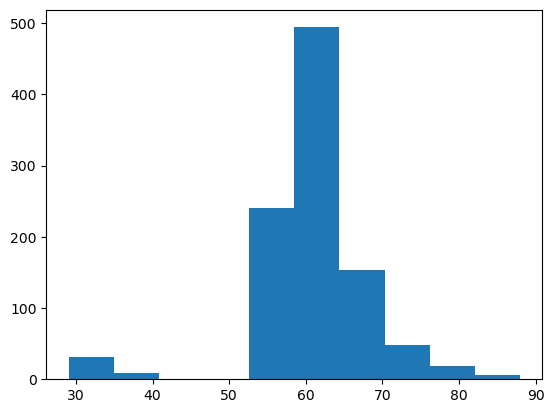

In [22]:
plt.hist(df['Freshness_Score'])

<Axes: >

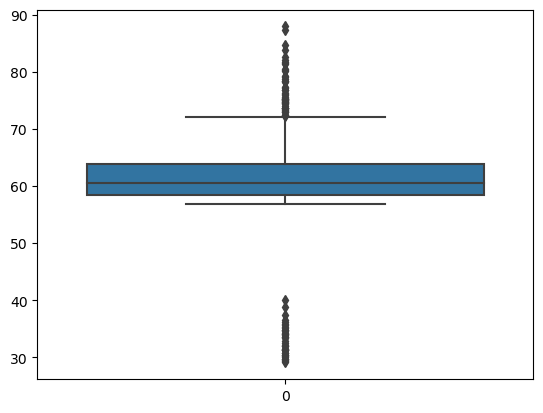

In [23]:

import seaborn as sns
sns.boxplot(df['Freshness_Score'])

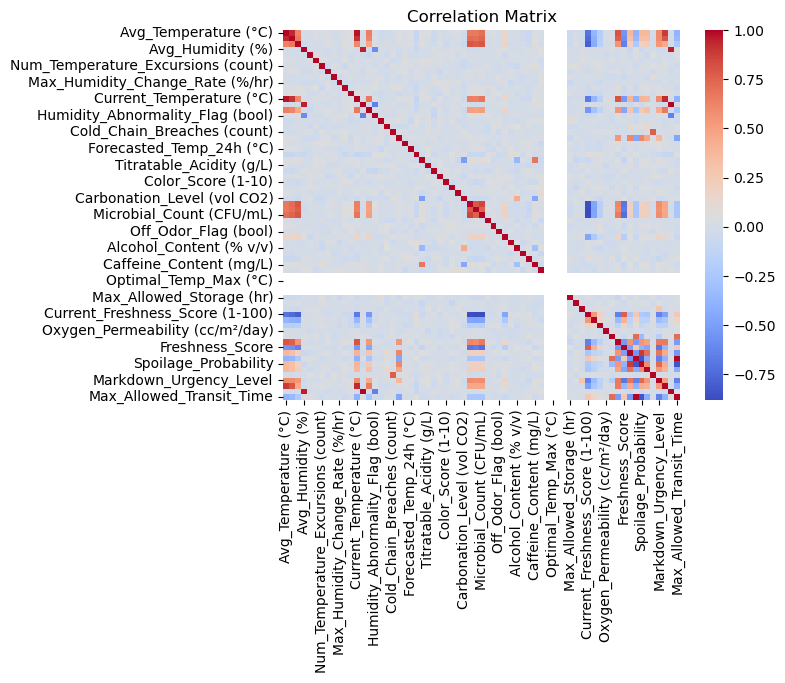

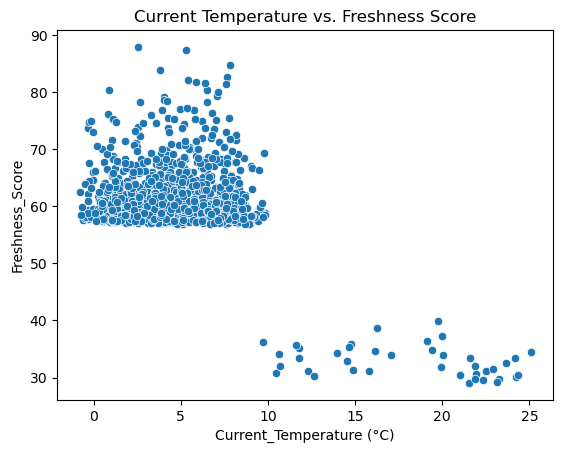

In [24]:
# Correlation matrix
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Scatter plot: Temperature vs. Freshness
sns.scatterplot(x='Current_Temperature (°C)', y='Freshness_Score', data=df)
plt.title('Current Temperature vs. Freshness Score')
plt.show()


In [25]:
df[df['Freshness_Score']<40]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
25,SKU0026,RTD Tea,Orange,Can,2025-06-19,2025-09-22,BATCH0026,22.685214,31.336962,20.118082,...,32.505418,99.999992,0.771549,0.982988,1,0,5,8.000000,79.872501,102.460906
50,SKU0051,Kombucha,Ginger-Lime,Glass,2025-06-20,2025-07-26,BATCH0051,21.713909,28.676973,47.262929,...,30.471812,99.999982,0.319173,0.972993,1,1,5,8.000000,69.243216,40.963705
75,SKU0076,Energy Drink,Apple,Glass,2025-06-17,2025-08-08,BATCH0076,12.655902,18.862046,47.454944,...,34.253236,99.999740,0.692052,0.978791,1,0,5,8.000000,84.191633,92.243725
100,SKU0101,Juice,Orange,PET,2025-06-18,2025-08-23,BATCH0101,22.833450,32.062916,31.693931,...,29.272540,99.999991,0.426311,0.980692,1,0,5,8.000000,71.886556,56.605526
125,SKU0126,Soda,Cola,PET,2025-06-16,2025-09-01,BATCH0126,20.513368,29.236910,12.576969,...,29.591058,99.999981,0.559625,0.967087,1,0,5,8.000000,82.169994,75.213655
150,SKU0151,Energy Drink,Peach,Glass,2025-06-19,2025-07-11,BATCH0151,10.143691,17.144997,41.556186,...,30.723629,99.998835,0.414945,0.980938,1,1,5,7.223769,72.744076,55.494665
175,SKU0176,RTD Coffee,Peach,PET,2025-06-22,2025-07-21,BATCH0176,12.016155,19.919079,35.308350,...,31.215214,99.998694,0.847933,0.965801,1,0,5,8.000000,70.713117,113.962203
200,SKU0201,RTD Tea,Orange,Glass,2025-06-22,2025-09-05,BATCH0201,15.616824,25.432063,42.699831,...,35.865305,99.999778,1.167530,0.976467,1,0,5,8.000000,67.217033,153.081667
225,SKU0226,Soda,Lemon,Tetra Pak,2025-06-22,2025-08-18,BATCH0226,11.794650,20.355139,29.295205,...,35.143473,99.998260,1.791625,0.975294,1,1,5,7.901732,80.197026,238.827021


In [26]:

df[df['Markdown_Urgency_Level']<2]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
2,SKU0003,Kombucha,Mango,PET,2025-06-23,2025-09-14,BATCH0003,6.065815,9.649784,7.598338,...,60.758434,60.454609,6.776904,0.478808,0,0,1,5.101447,82.925984,909.674465
9,SKU0010,Soda,Orange,Glass,2025-06-17,2025-07-30,BATCH0010,0.284127,2.923809,6.160253,...,59.358866,31.645152,5.063748,0.431315,0,1,1,1.827619,83.553647,676.598838
11,SKU0012,RTD Coffee,Peach,PET,2025-06-17,2025-07-14,BATCH0012,0.225777,2.569627,4.203206,...,61.657593,21.345908,3.258730,0.472716,0,0,1,2.129860,75.362368,433.398779
17,SKU0018,Kombucha,Apple,Tetra Pak,2025-06-24,2025-08-21,BATCH0018,5.961428,6.196568,3.219585,...,68.529659,32.940237,5.030269,0.414791,0,1,1,4.613314,80.606643,675.759477
19,SKU0020,RTD Coffee,Ginger-Lime,Can,2025-06-19,2025-09-05,BATCH0020,0.413136,1.430405,1.893519,...,64.023390,48.710468,6.512636,0.442550,0,0,1,2.294427,68.611495,873.503432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,SKU0941,RTD Tea,Berry,Tetra Pak,2025-06-19,2025-08-19,BATCH0941,0.803396,5.549109,3.968347,...,66.207747,5.114975,8.972645,0.078738,0,0,1,2.033688,73.884797,1201.187620
965,SKU0966,RTD Coffee,Apple,PET,2025-06-18,2025-08-21,BATCH0966,0.684089,3.968215,4.627485,...,57.479862,40.966398,7.081882,0.339937,0,0,1,2.069185,77.074301,951.750036
967,SKU0968,Juice,Mango,Tetra Pak,2025-06-16,2025-09-22,BATCH0968,0.128898,3.759419,4.784624,...,58.424387,70.261403,9.093646,0.370953,0,1,1,1.623883,78.011275,1217.632052
978,SKU0979,Soda,Berry,Can,2025-06-21,2025-08-18,BATCH0979,2.853480,7.691994,0.772976,...,67.942860,29.196638,5.978773,0.298631,0,1,1,3.532112,82.215297,798.502841


In [27]:
df[df['High_Risk_Flag']==1]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,29.752426,99.999992,0.502006,0.965253,1,0,5,8.000000,79.691757,66.029457
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,59.598705,90.447451,6.299582,0.730469,1,1,2,6.733730,70.151765,841.461346
6,SKU0007,Juice,Mango,Tetra Pak,2025-06-17,2025-07-31,BATCH0007,2.977608,6.016317,7.256808,...,58.633629,96.595154,1.984685,0.928935,1,0,3,4.141375,73.840760,261.018188
8,SKU0009,Juice,Peach,Glass,2025-06-24,2025-07-11,BATCH0009,6.932493,11.354882,5.284452,...,66.067132,86.283055,0.918809,0.917712,1,0,3,5.733481,74.469941,120.991581
14,SKU0015,RTD Tea,Apple,PET,2025-06-23,2025-08-19,BATCH0015,2.621241,5.100717,6.210616,...,58.285815,95.030355,2.688822,0.910667,1,1,3,4.049233,79.951262,358.529002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,SKU0991,Juice,Ginger-Lime,Glass,2025-06-17,2025-09-08,BATCH0991,1.361053,5.941460,4.439546,...,59.312132,90.026831,5.309039,0.769823,1,0,2,3.146313,70.815483,708.217927
991,SKU0992,Kombucha,Cola,Tetra Pak,2025-06-23,2025-09-03,BATCH0992,7.958096,12.721962,7.034102,...,58.289076,96.462045,3.993417,0.868365,1,0,3,6.524819,73.761015,531.390282
993,SKU0994,Energy Drink,Apple,Can,2025-06-20,2025-09-16,BATCH0994,6.911773,7.445446,3.099832,...,59.475084,86.978318,5.870347,0.739449,1,0,2,6.259215,79.612660,786.055981
994,SKU0995,Energy Drink,Ginger-Lime,Glass,2025-06-18,2025-08-28,BATCH0995,6.797326,8.858623,1.502612,...,57.989269,97.562574,2.575182,0.901018,1,0,3,5.637860,70.133840,342.228267


In [28]:
df['Expiry_Date (YYYY-MM-DD)']

0     2025-09-04
1     2025-09-13
2     2025-09-14
3     2025-07-26
4     2025-09-02
         ...    
995   2025-08-11
996   2025-08-01
997   2025-07-18
998   2025-08-17
999   2025-08-22
Name: Expiry_Date (YYYY-MM-DD), Length: 1000, dtype: datetime64[ns]

In [29]:
df['Production_Date (YYYY-MM-DD)']

0     2025-06-22
1     2025-06-17
2     2025-06-23
3     2025-06-17
4     2025-06-24
         ...    
995   2025-06-22
996   2025-06-20
997   2025-06-16
998   2025-06-20
999   2025-06-16
Name: Production_Date (YYYY-MM-DD), Length: 1000, dtype: datetime64[ns]

In [30]:
df.shape

(1000, 83)

In [31]:
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,accuracy_score,r2_score
import joblib

In [32]:
x=df.iloc[:,:72]
y=df.iloc[:,72:]

In [33]:
x

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Optimal_Humidity_Max (%),Max_Allowed_Storage (hr),Regulatory_Compliance_Flag (bool),Priority_Level (1-10),Current_Freshness_Score (1-100),Predicted_Remaining_Shelf_Life (hr),Packaging_Integrity_Flag (bool),Oxygen_Permeability (cc/m²/day),Preservative_Treatment,Target_Shelf_Life_Weeks
0,SKU0001,RTD Tea,Ginger-Lime,Can,2025-06-22,2025-09-04,BATCH0001,22.755191,31.601694,29.135423,...,90,107,False,4,0.000000,0.000000,False,62.995093,Benzoate,10.571429
1,SKU0002,RTD Tea,Ginger-Lime,Glass,2025-06-17,2025-09-13,BATCH0002,7.877855,12.009460,2.022458,...,90,62,True,3,82.558145,47.883724,False,198.688510,Pasteurized,12.571429
2,SKU0003,Kombucha,Mango,PET,2025-06-23,2025-09-14,BATCH0003,6.065815,9.649784,7.598338,...,90,138,False,1,94.607126,81.362128,False,186.751181,UHT,11.857143
3,SKU0004,Kombucha,Mango,Glass,2025-06-17,2025-07-26,BATCH0004,0.674011,1.859216,0.932912,...,90,68,False,1,88.768339,66.576254,True,120.792699,Pasteurized,5.571429
4,SKU0005,RTD Coffee,Cola,Glass,2025-06-24,2025-09-02,BATCH0005,1.588974,1.633956,2.048271,...,90,74,True,9,78.011978,117.798087,True,118.241961,Sorbate,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,SKU0996,Soda,Orange,Glass,2025-06-22,2025-08-11,BATCH0996,1.216070,1.565019,3.975086,...,90,130,False,1,81.621199,91.415743,True,16.001659,Sorbate,7.142857
996,SKU0997,RTD Tea,Cola,Can,2025-06-20,2025-08-01,BATCH0997,5.644314,7.090071,2.458001,...,90,150,False,1,89.349097,58.076913,True,157.233559,Pasteurized,6.000000
997,SKU0998,Kombucha,Cola,Glass,2025-06-16,2025-07-18,BATCH0998,5.576072,9.638454,7.358590,...,90,91,True,9,83.321318,83.321318,False,134.417206,NaN,4.571429
998,SKU0999,Soda,Mango,Tetra Pak,2025-06-20,2025-08-17,BATCH0999,0.498794,4.805411,6.737286,...,90,171,False,8,88.798129,108.333717,False,94.356501,Pasteurized,8.285714


In [34]:
numeric_features=x.select_dtypes(include=np.number).columns.tolist()
categorical_features=x.select_dtypes(exclude=np.number).columns.tolist()

In [35]:
numeric_features

['Avg_Temperature (°C)',
 'Max_Temperature (°C)',
 'Time_Above_Temp_Threshold (hr)',
 'Avg_Humidity (%)',
 'Max_Humidity_Excursion (%)',
 'Time_Outside_Humidity_Range (hr)',
 'Num_Temperature_Excursions (count)',
 'Num_Humidity_Excursions (count)',
 'Max_Temp_Change_Rate (°C/hr)',
 'Max_Humidity_Change_Rate (%/hr)',
 'Door_Open_Count (count)',
 'Handling_Event_Count (count)',
 'Current_Temperature (°C)',
 'Current_Humidity (%)',
 'Supplier_Quality_Score (1-100)',
 'Transit_Delay_Hours (hr)',
 'Cold_Chain_Breaches (count)',
 'Storage_Duration (hr)',
 'Weather_Risk_Score (1-10)',
 'Forecasted_Temp_24h (°C)',
 'Forecasted_Humidity_24h (%)',
 'pH',
 'Titratable_Acidity (g/L)',
 'Soluble_Solids_Content (°Brix)',
 'Turbidity (NTU)',
 'Color_Score (1-10)',
 'Aroma_Score (1-10)',
 'Taste_Score (1-10)',
 'Carbonation_Level (vol CO2)',
 'Respiration_Rate (mg CO2/L·hr)',
 'Ammonia_Release_Rate (ppm)',
 'Microbial_Count (CFU/mL)',
 'Yeast_Mold_Count (CFU/mL)',
 'Preservative_Residual (mg/L)',
 'Al

In [36]:
categorical_features

['SKU_ID',
 'Product_Kind',
 'Flavor/Variety',
 'Packaging_Type',
 'Production_Date (YYYY-MM-DD)',
 'Expiry_Date (YYYY-MM-DD)',
 'Batch_ID',
 'First_Temp_Excursion_Timestamp (YYYY-MM-DD HH:MM)',
 'Last_Temp_Excursion_Timestamp (YYYY-MM-DD HH:MM)',
 'First_Humidity_Excursion_Timestamp (YYYY-MM-DD HH:MM)',
 'Last_Humidity_Excursion_Timestamp (YYYY-MM-DD HH:MM)',
 'Temp_Abnormality_Flag (bool)',
 'Humidity_Abnormality_Flag (bool)',
 'Shelf_Microclimate_ID',
 'Supplier_Name',
 'Transport_Mode',
 'Weather_Forecast',
 'Off_Odor_Flag (bool)',
 'Spoilage_Flag (bool)',
 'Sediment_Flag (bool)',
 'Regulatory_Compliance_Flag (bool)',
 'Packaging_Integrity_Flag (bool)',
 'Preservative_Treatment']

In [37]:
preprocessor=ColumnTransformer(transformers=[
    ('num',Pipeline([
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler',StandardScaler())
    ]),numeric_features),
    ('cat',Pipeline([
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
    ]),categorical_features)
])

In [38]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [39]:
y_train

,Degradation_Rate,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
29,0.026084,61.342767,84.585482,2.620484,0.865246,0,0,3,2.911771,67.690536,346.302302
535,0.029344,60.839650,86.797787,5.686740,0.741362,1,1,3,4.495631,74.059063,760.758157
695,0.024745,57.906744,91.799277,5.950737,0.741696,1,1,2,2.754886,75.502681,794.728093
557,0.023894,63.605604,69.867816,2.738099,0.817010,0,1,2,2.270391,68.101141,362.849240
836,0.022026,63.314839,63.551188,3.531623,0.744280,0,1,3,5.613400,66.965138,469.639406
...,...,...,...,...,...,...,...,...,...,...,...
106,0.038391,65.444546,81.788075,3.311924,0.843011,0,0,3,5.940489,67.182465,444.328352
270,0.022790,57.461918,91.213848,2.521360,0.907448,1,0,3,2.576884,66.825395,333.607021
860,0.026761,61.770617,81.584530,1.780618,0.888713,0,1,3,3.757168,75.505197,234.997656
435,0.042261,57.642118,97.935428,1.636741,0.935974,1,1,3,5.940242,84.599995,215.030223


In [40]:
models={}
classification_indices=[5,6,7]


In [41]:
for i, target in enumerate(y.columns):
    
    if i in classification_indices:
        model=GradientBoostingClassifier(n_estimators=200,max_depth=4,learning_rate=0.07,subsample=0.9,random_state=42)
        scoring='accuracy'
    else:
        model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.07,subsample=0.9,
        random_state=42)
        scoring='r2'
    
    pipeline = Pipeline([
        ('preprocessor',preprocessor),
        ('model',model)
    ])
    
    
    
    if i in classification_indices:
        cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
        cv_scores=cross_val_score(pipeline,x_train,y_train.iloc[:,i],cv=cv,scoring=scoring)
        print(f"Cross-validated Accuracy for {target}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    else:
        cv = 5
        cv_scores = cross_val_score(pipeline, x_train, y_train.iloc[:, i], cv=cv, scoring=scoring)
        print(f"Cross-validated R2 for {target}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
              
    pipeline.fit(x_train,y_train.iloc[:,i])
    y_pred=pipeline.predict(x_test)
                    
    if i in classification_indices:
        acc = accuracy_score(y_test.iloc[:, i], y_pred)
        print(f'Output column {72+i} ({target}) Accuracy: {acc:.4f}')  # Fixed
    else:
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred)
        r2 = r2_score(y_test.iloc[:, i], y_pred)
        print(f'Output column {72+i} ({target}) MAE: {mae:.4f}, R2: {r2:.4f}')
              
    joblib.dump(pipeline, f'output_col_{72+i}_{target}_pipeline.pkl')
    models[f'output_col_{72+i}_{target}'] = pipeline          
    

Cross-validated R2 for Degradation_Rate: 0.9363 ± 0.0497
Output column 72 (Degradation_Rate) MAE: 0.0006, R2: 0.9775
Cross-validated R2 for Freshness_Score: 0.9974 ± 0.0023
Output column 73 (Freshness_Score) MAE: 0.0934, R2: 0.9990
Cross-validated R2 for Risk_Score: 0.9543 ± 0.0127
Output column 74 (Risk_Score) MAE: 2.6981, R2: 0.9722
Cross-validated R2 for Remaining_Shelf_Life: 0.9727 ± 0.0042
Output column 75 (Remaining_Shelf_Life) MAE: 0.2232, R2: 0.9772
Cross-validated R2 for Spoilage_Probability: 0.9256 ± 0.0149
Output column 76 (Spoilage_Probability) MAE: 0.0377, R2: 0.9424
Cross-validated Accuracy for High_Risk_Flag: 0.9238 ± 0.0127
Output column 77 (High_Risk_Flag) Accuracy: 0.9250
Cross-validated Accuracy for Reroute_Recommended_Flag: 1.0000 ± 0.0000
Output column 78 (Reroute_Recommended_Flag) Accuracy: 1.0000
Cross-validated Accuracy for Markdown_Urgency_Level: 0.8513 ± 0.0145
Output column 79 (Markdown_Urgency_Level) Accuracy: 0.8700
Cross-validated R2 for Recommended_Temper

In [42]:
sample_input = x_test.iloc[0:1]
predictions = {target: model.predict(sample_input) for target, model in models.items()}
print(predictions)

{'output_col_72_Degradation_Rate': array([0.01835133]), 'output_col_73_Freshness_Score': array([59.60035102]), 'output_col_74_Risk_Score': array([62.45583275]), 'output_col_75_Remaining_Shelf_Life': array([5.97246639]), 'output_col_76_Spoilage_Probability': array([0.59842314]), 'output_col_77_High_Risk_Flag': array([0], dtype=int64), 'output_col_78_Reroute_Recommended_Flag': array([0], dtype=int64), 'output_col_79_Markdown_Urgency_Level': array([2], dtype=int64), 'output_col_80_Recommended_Temperature': array([2.13397081]), 'output_col_81_Recommended_Humidity': array([69.79938462]), 'output_col_82_Max_Allowed_Transit_Time': array([785.99798948])}


In [43]:
y_test.iloc[0:1]

,Degradation_Rate,Freshness_Score,Risk_Score,Remaining_Shelf_Life,Spoilage_Probability,High_Risk_Flag,Reroute_Recommended_Flag,Markdown_Urgency_Level,Recommended_Temperature,Recommended_Humidity,Max_Allowed_Transit_Time
521,0.018427,59.501215,61.479717,5.53545,0.565244,0,0,2,2.131328,69.781563,740.363335


In [44]:
x_test.iloc[0:1]

,SKU_ID,Product_Kind,Flavor/Variety,Packaging_Type,Production_Date (YYYY-MM-DD),Expiry_Date (YYYY-MM-DD),Batch_ID,Avg_Temperature (°C),Max_Temperature (°C),Time_Above_Temp_Threshold (hr),...,Optimal_Humidity_Max (%),Max_Allowed_Storage (hr),Regulatory_Compliance_Flag (bool),Priority_Level (1-10),Current_Freshness_Score (1-100),Predicted_Remaining_Shelf_Life (hr),Packaging_Integrity_Flag (bool),Oxygen_Permeability (cc/m²/day),Preservative_Treatment,Target_Shelf_Life_Weeks
521,SKU0522,Kombucha,Peach,PET,2025-06-24,2025-08-23,BATCH0522,0.810238,1.412667,1.347505,...,90,149,False,2,84.620242,126.08416,False,139.472061,Pasteurized,8.571429
